In [36]:
#自动重载
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2
from PIL import ImageEnhance
from utils import mask2yolo,make_pic,make_noise
from tqdm import tqdm
mainpath = "./datasets/"
bg_path = "bg/"
fg_path = "fg_2/"
masks_path = "masks/"
fgs = os.listdir(mainpath+fg_path)
bgs = os.listdir(mainpath+bg_path)
masks = os.listdir(mainpath+masks_path)

In [57]:
def make_pic(fgs_,bg,masks_):
    # 读入的是路径，
    assert len(fgs_) == len(masks_), "前景图像与掩膜数量必须相等"
    fgs = []
    masks = []
    bg = Image.open(bg)
    for fg_, mask_ in zip(fgs_, masks_):
        fg = Image.open(fg_)
        mask = Image.open(mask_)
        fgs.append(fg)
        masks.append(mask)
    # 先不考虑旋转了，只考虑平移
    do_rotation = True
    do_translation = True
    do_scale = True
    do_flip = True
    do_color_transformation = True
    do_noise_injection = True
    blank_mask = Image.new("L",bg.size,0)
    target_cnt = 0
    for fg, mask in zip(fgs, masks):
        # 将fg resize到可以接受的大小，然后把fg叠加到bg上，然后根据这一步的操作将mask也变换到与bg一样的空白图片上
        # 1. resize fg
        # 计算比例 使fg的长宽都小于bg
        # 如果本来就小于bg就不用resize了
        if do_rotation:
            angle = np.random.randint(0,360)
            fg = fg.rotate(angle,resample=Image.BICUBIC,expand=True)
            mask = mask.rotate(angle,resample=Image.BICUBIC,expand=True)
        if do_scale:
            scale = np.random.uniform(0.5,1.5)
            # resize
            fg = fg.resize((int(fg.size[0]*scale),int(fg.size[1]*scale)))
            # mask也resize
            mask = mask.resize((int(mask.size[0]*scale),int(mask.size[1]*scale)))
        if do_flip:
            if np.random.randint(0,2):
                fg = fg.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        if do_color_transformation:
            enhancer = ImageEnhance.Color(fg)
            fg = enhancer.enhance(np.random.uniform(0.5, 1.5))  # 对颜色进行增强，值大于1表示增强，小于1表示减弱



        if fg.size[0] >= bg.size[0] or fg.size[1] >= bg.size[1]:
            scale = min(bg.size[0]/fg.size[0],bg.size[1]/fg.size[1])/1.2
            # resize
            fg = fg.resize((int(fg.size[0]*scale),int(fg.size[1]*scale)))
            # mask也resize
            mask = mask.resize((int(mask.size[0]*scale),int(mask.size[1]*scale)))
        # 防止fg太小 至少得是bg的一半大小
        if fg.size[0] < bg.size[0]/2 and fg.size[1] < bg.size[1]/2:
            scale = min(bg.size[0]/fg.size[0],bg.size[1]/fg.size[1])/1.5
            # resize
            fg = fg.resize((int(fg.size[0]*scale),int(fg.size[1]*scale)))
            # mask也resize
            mask = mask.resize((int(mask.size[0]*scale),int(mask.size[1]*scale)))

        # 随机生成一个位置
        # 生成的位置是fg的左上角的位置 需要保证右下角的位置在bg内
        max_x = bg.size[0] - fg.size[0]
        max_y = bg.size[1] - fg.size[1]
        #print(max_x,max_y)
        # 生成随机位置
        new_x = np.random.randint(0,max_x)
        new_y = np.random.randint(0,max_y)
        # 将fg叠加到bg上 注意透明图层
        # 判断是否叠加的时候叠加到了之前的mask上
        bg.paste(fg, (new_x, new_y), fg)

        # 3. 将mask也变换到与bg一样的全0图片上（无透明图层），然后将mask直接叠加上去
        #print(mask)
        mask = mask.convert("L")
        temp = Image.new("L",bg.size,0)
        temp.paste(mask,(new_x,new_y),mask)
        if not np.logical_and(np.array(blank_mask),np.array(temp)).any():
            target_cnt += 1
        #判断是否叠加的时候叠加到了之前的mask上

        blank_mask.paste(mask, (new_x, new_y), mask)
        
        # 噪声注入
        if do_noise_injection:
            noise = np.random.normal(0, np.random.randint(0,32), (bg.size[1], bg.size[0], 3))
            bg = Image.fromarray((np.array(bg) + noise).clip(0,255).astype(np.uint8))
    return bg, blank_mask, target_cnt

In [69]:
test_fg_list = [mainpath+fg_path+fg for fg in fgs[:2]]
test_bg = mainpath+bg_path+bgs[0]
test_mask_list = [mainpath+masks_path+mask for mask in masks[:2]]
mixed_pic,mixed_mask,target_cnt = make_pic(test_fg_list,test_bg,test_mask_list)

1


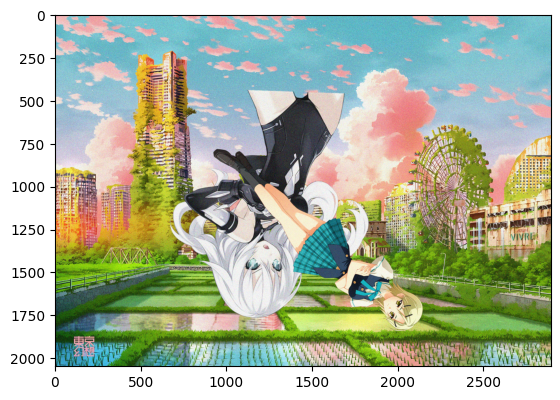

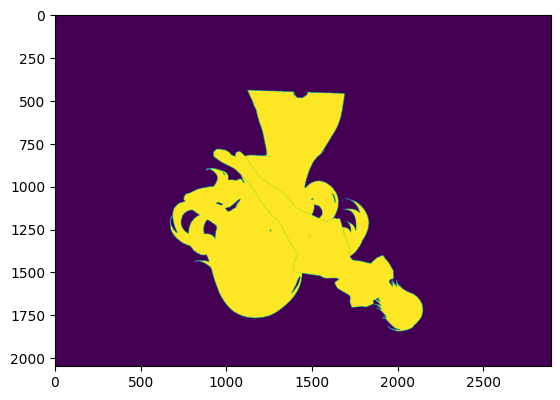

In [70]:
# 打印出来看看
print(target_cnt)
plt.imshow(mixed_pic)
plt.show()
mixed_mask = np.array(mixed_mask)
plt.imshow(mixed_mask)
plt.show()

In [67]:
def mask2yolo(mask_img, item_nums,show = False):
    #如果是PIL的Image格式就转换成np的array
    if isinstance(mask_img,Image.Image):
        mask_img = np.array(mask_img)
    poligons = []
    size = []
    img = mask_img
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for object in contours:
        coords = []
        for point in object:
            coords.append(int(point[0][0]))
            coords.append(int(point[0][1]))
        poligons.append(coords)
        size.append(len(coords))
    # 保留最大的item_nums个轮廓
    #print(np.argsort(size)[-item_nums:])
    print(np.argsort(size)[-item_nums:])
    temp = []
    for i in np.argsort(size)[-item_nums:]:
        temp.append(poligons[i])
    poligons = temp
    # 画出轮廓
    zeros = np.zeros(img.shape, np.uint8)
    print(len(poligons))
    #保存为yolo的str
    yolo_str = ""
    if show:
        for poligon in poligons:
            cv2.fillPoly(zeros, [np.array(poligon).reshape(-1, 2)], (255, 255, 255))
        cv2.waitKey(0)
    for poligon in poligons:
        yolo_str += "0 "
        for j in range(0,len(poligon),2):
            yolo_str += str(poligon[j]/img.shape[1])+" "+str(poligon[j+1]/img.shape[0])+" "
        yolo_str += "\n"
    return yolo_str, zeros

[23  7]
2


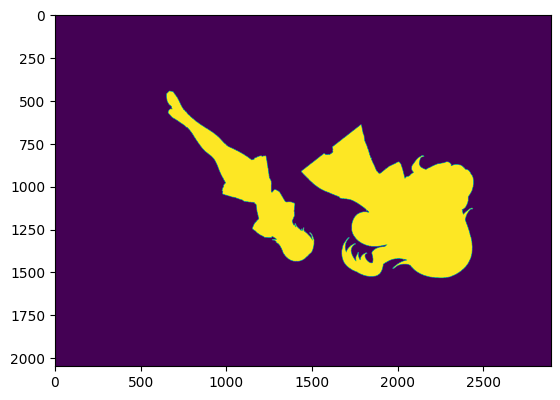

In [68]:
yolo, mas = mask2yolo(mixed_mask,target_cnt,show=True)
plt.imshow(mas)

In [62]:
def add_noise(img, show=False):
    # 保证img是PIL的Image格式
    assert isinstance(img, Image.Image)
    # 生成随机噪声
    noise = np.random.randint(0,255,(img.size[1],img.size[0],3),dtype=np.uint8)
    noise = Image.fromarray(noise)
    #return noise
    # 将噪声叠加到img上
    img = Image.composite(img,noise,img)
    if show:
        img.show()
    return img

In [33]:
add_noise(mixed_pic)

ValueError: bad transparency mask

In [10]:
# 为每个fg都生成一个yolo的
# 生成的yolo格式的mask保存在./datasets/masks_yolo/下
# 生成的叠加后的图片保存在./datasets/mixed_pic/下
# 改成tqdm的形式，可以看到进度条
if not os.path.exists(mainpath+"masks_yolo/"):
    os.mkdir(mainpath+"masks_yolo/")
if not os.path.exists(mainpath+"mixed_pic/"):
    os.mkdir(mainpath+"mixed_pic/")
if not  os.path.exists(mainpath+"mixed_mask/"):
    os.mkdir(mainpath+"mixed_mask/")
for n in tqdm(range(len(fgs)), desc='Processing images'):
    fg = fgs[n]
    bg = bgs[np.random.randint(0,len(bgs))]
    mask = masks[n]
    fg_pic = Image.open(mainpath+fg_path+fg)
    bg_pic = Image.open(mainpath+bg_path+bg)
    mask_pic = Image.open(mainpath+masks_path+mask)
    mixed_pic, mixed_mask = make_pic(fg_pic, bg_pic, mask_pic)
    mixed_pic.save(mainpath+"mixed_pic/"+fg[:-4]+"_"+bg[:-4]+".jpg")
    mixed_mask.save(mainpath+"mixed_mask/"+fg[:-4]+"_"+bg[:-4]+".jpg")
    yolo = mask2yolo(mixed_mask, show=False)
    with open(mainpath+"masks_yolo/"+fg[:-4]+"_"+bg[:-4]+".txt","w") as f:
        f.write(yolo[0])
    

Processing images:   0%|          | 0/11789 [00:00<?, ?it/s]


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U17'), dtype('uint8')) -> None